In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from scipy.io import mmread

# Define the file paths
file_path = '/content/drive/My Drive/3sources/3sources/'
file_names = ['3sources_bbc.mtx',
              '3sources_guardian.mtx',
              '3sources_reuters.mtx']

# Initialize an empty array to store the arrays
X = np.empty((len(file_names),), dtype=object)

# Load data from each file into a NumPy array and store in X
for i, file_name in enumerate(file_names):
    file = file_path + file_name
    array = mmread(file).toarray()  # Convert the sparse matrix to a dense array
    X[i] = array

# Print the shape of the resulting array
print("Shape of X:", X.shape)

Shape of X: (3,)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardize the data (zero mean, unit variance)
scaler = StandardScaler()

view1_normalized = scaler.fit_transform(X[0])
view2_normalized = scaler.fit_transform(X[1])
view3_normalized = scaler.fit_transform(X[2])


In [ ]:
print(view1_normalized.shape)

(3560, 352)


In [ ]:
import numpy as np

# Define datasets
dataset_1 = view1_normalized
dataset_2 = view2_normalized
dataset_3 = view3_normalized

# Ensure each dataset has at most 3068 samples
dataset_1 = dataset_1[:3068, :]
dataset_2 = dataset_2[:3068, :]
dataset_3 = dataset_3[:3068, :]

# Transpose each dataset
X[0] = dataset_1.T
X[1] = dataset_2.T
X[2] = dataset_3.T

# Print the shapes to verify
print("Original shapes:")
print("View 1:", dataset_1.shape)
print("View 2:", dataset_2.shape)
print("View 3:", dataset_3.shape)
print("\nTransposed shapes:")
print("View 1 transposed:", X[0].shape)
print("View 2 transposed:", X[1].shape)
print("View 3 transposed:", X[2].shape)


Original shapes:
View 1: (3068, 352)
View 2: (3068, 302)
View 3: (3068, 294)

Transposed shapes:
View 1 transposed: (352, 3068)
View 2 transposed: (302, 3068)
View 3 transposed: (294, 3068)


In [ ]:
num_features = [array.shape[0] for array in X]

# Print the number of features for each dataset
for i, num_feat in enumerate(num_features):
    print(f"Number of features in dataset {i+1}: {num_feat}")


Number of features in dataset 1: 352
Number of features in dataset 2: 302
Number of features in dataset 3: 294


In [ ]:
# Initialize a list to store the densities
densities = []

# Calculate density of non-zero entries for each array in X
for i, array in enumerate(X):
    density = np.count_nonzero(array) / np.prod(array.shape)
    densities.append(density)
    print("Density of non-zero entries in dataset", i+1, ":", density)

# Overall density
overall_density = sum(densities) / len(densities)
print("Overall density:", overall_density)


Density of non-zero entries in dataset 1 : 1.0
Density of non-zero entries in dataset 2 : 1.0
Density of non-zero entries in dataset 3 : 1.0
Overall density: 1.0


In [ ]:
X[0] = X[0][:294, :700]
X[1] = X[1][:294, :700]
X[2] = X[2][:, :700]


In [ ]:
import numpy as np
W = []
def generate_W(m):
    k = len(X)
    for j in range(k):
        d = X[j].shape[0]
        W_k = np.random.rand(d, m)
        # Apply ℓ2,0 norm constraint
        norm = np.linalg.norm(W_k, axis=0, ord=2)
        mask = (norm != 0)
        indices = np.argsort(norm)[::-1][:m]
        W_k[:, ~mask] = 0
        W_k /= norm
        W.append(W_k)
    return W

# k: the number of views
k = len(X)
W_list = generate_W(50)

# Stack the arrays along a new axis (axis=0)
W_array = np.stack(W_list, axis=0)

# Print the shape of the stacked array
print("Shape of stacked array W_array:", W_array.shape)

# Print the elements of W_array
for i in range(k):
    print("\nW matrices:")
    print(f"W{i+1}:\n{W_array[i]}\n")


Shape of stacked array W_array: (3, 294, 50)

W matrices:
W1:
[[0.04925007 0.10569778 0.09736999 ... 0.08449145 0.00763151 0.01473737]
 [0.0389302  0.06292036 0.02615818 ... 0.09120564 0.00157473 0.04327066]
 [0.05266861 0.07785529 0.05764144 ... 0.00103055 0.03681839 0.01013045]
 ...
 [0.03845119 0.08981503 0.08028263 ... 0.06502524 0.02981905 0.06484073]
 [0.03205393 0.08363201 0.04855141 ... 0.08177029 0.03951075 0.07256522]
 [0.0637897  0.0949742  0.05733717 ... 0.02873259 0.03543393 0.07236373]]


W matrices:
W2:
[[0.02933593 0.07245391 0.02266463 ... 0.03293764 0.04944454 0.07989466]
 [0.0804002  0.06008581 0.02517012 ... 0.10195135 0.09945632 0.05929966]
 [0.08855048 0.05291396 0.01943878 ... 0.03917774 0.0014126  0.06985429]
 ...
 [0.07672804 0.0070056  0.0502775  ... 0.0578043  0.05772693 0.0820275 ]
 [0.08770233 0.04727184 0.01332991 ... 0.06452724 0.04123052 0.0465008 ]
 [0.05025181 0.06147101 0.03222805 ... 0.02843773 0.04036174 0.04589376]]


W matrices:
W3:
[[0.06457088 0

In [ ]:
import numpy as np

def generate_G(k, m, C):
    G = np.zeros((k, m, C))
    for i in range(k):
        G[i] = np.random.rand(m, C)
    return G


def generate_F(N, C):
    F = np.zeros((N, C))
    for i in range(N):
        # Choose a random cluster for the ith sample
        c = np.random.randint(0, C)
        F[i, c] = 1
    return F


def generate_alpha(k):
    alpha = np.ones(k) / k
    return alpha

In [ ]:
N = X[0].shape[1]
print(N)

700


In [ ]:
C = 10
m = 50
k =3
G = generate_G(k, m, C)

F = generate_F(N, C)
alpha = generate_alpha(k)

print("\nG matrices:")
for i, G_k in enumerate(G):
    print(f"G{i+1}:\n{G_k}\n")

print("\nF matrices:")
print(F)


print("\nAlpha vector:")
print(alpha)


G matrices:
G1:
[[2.02331049e-01 5.93059977e-01 6.10705844e-01 7.70439194e-01
  5.23928135e-01 1.64611597e-01 8.29283121e-01 1.90911606e-01
  7.06379540e-01 7.78599675e-03]
 [2.89636074e-01 3.47293431e-01 4.88954577e-01 1.45938264e-01
  9.93981945e-01 2.00049301e-01 8.06102677e-01 5.49682065e-01
  9.49028896e-02 9.22407725e-01]
 [1.02598506e-01 7.77927741e-01 1.30998185e-01 6.70674622e-02
  5.56390622e-01 3.03690856e-01 9.53402541e-01 2.46028378e-02
  6.31300733e-01 8.89595320e-01]
 [4.21913292e-02 3.50501007e-01 3.00339763e-01 3.92936225e-03
  2.85856155e-01 1.65468819e-01 7.77997199e-01 9.03075929e-01
  4.59368439e-01 9.73117509e-01]
 [3.97856647e-01 1.44799228e-01 4.31828199e-02 7.91792669e-01
  8.21668776e-01 2.57523467e-01 8.14562239e-01 5.70598542e-01
  4.85786313e-02 4.85723102e-01]
 [3.40189558e-01 5.59200539e-01 8.70775673e-01 6.59579790e-01
  4.63100879e-01 1.69356980e-01 7.62208868e-01 6.53145359e-01
  7.12397012e-01 7.50604291e-01]
 [4.13102203e-01 2.10735632e-01 2.5497562

In [ ]:
    d = X[0].shape[0]
    print(d)

294


In [ ]:
import numpy as np

def calculate_Q(X):
    # Calculate the number of features for the given view
    d = X.shape[0]
    n = X.shape[1]  # Number of samples

    # Calculate the centralized matrix H_n
    H_n = np.eye(n) - (1/n) * np.ones((n, n))

    # Initialize the redundancy matrix Q
    Q = np.zeros((d, d))

    # Compute the centralized features q_i and q_j for each pair of features
    for i in range(d):
        for j in range(d):
            # Compute the centralized features q_i and q_j
            q_i = np.dot(H_n, X[i])
            q_j = np.dot(H_n, X[j])

            # Calculate the dot product of q_i and q_j
            dot_product = np.dot(q_i, q_j)

            # Calculate the norms of q_i and q_j
            norm_q_i = np.linalg.norm(q_i)
            norm_q_j = np.linalg.norm(q_j)

            # Calculate the element Q(i, j)
            Q[i, j] = (dot_product / (norm_q_i * norm_q_j)) ** 2

    return Q

In [ ]:
Q = []  # Initialize Q as an empty list
for i in range(len(X)):
    Q.append(calculate_Q(X[i]))

In [ ]:
Q = np.array(Q)

In [ ]:
Q[0].shape

(294, 294)

# **UPDATE W**

# **Initialization: W , G , F , alpha**
#**for iter = 1 to max_iters do**
#       **2: Update Wv**
 #      **3: Update F**
  #     **4: Update Gv**
   #    **5: Update alpha**
   # **6: break;**
# **7: return W , G , F , alpha**

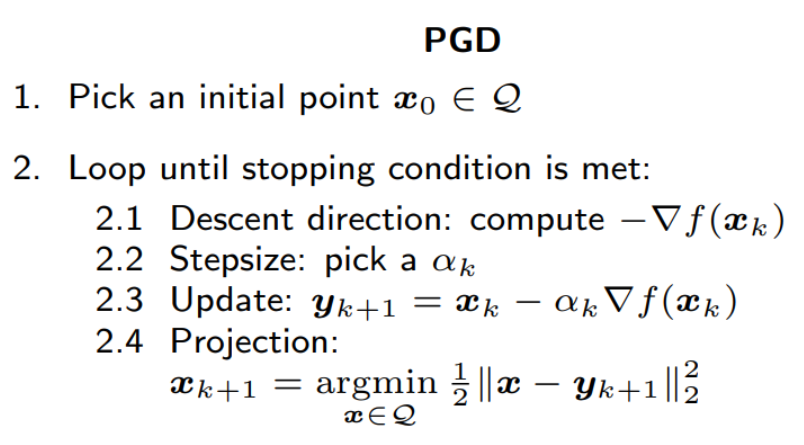

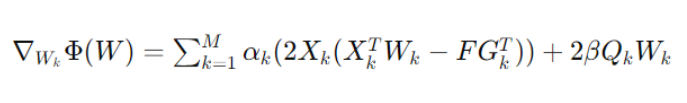

In [ ]:
import numpy as np

def compute_gradient_W(k, X_k, W_k, G_k, F, Q_k, alpha_k, beta):
    """
    Compute the gradient of the objective function with respect to W_k.

    Parameters:
    - X_k: Data matrix of shape (d, n)
    - W_k: Weight matrix of shape (d, m)
    - G_k: Matrix of shape (m, c)
    - F: Latent feature matrix of shape (n, c)
    - Q_k: Regularization matrix of shape (d, d)
    - alpha_k: Weighting coefficient for the loss term
    - beta: Regularization parameter for the W term

    Returns:
    - gradient_W_k: Gradient matrix of shape (d, m)

    """
    W_k = W[k]
    X_k = X[k]
    G_k = G[k]
    Q_k = Q[k]
    alpha_k = alpha[k]
    T1 = np.dot(X_k.T, W_k)
    T2 = np.dot(F, G_k.T)
    term1 = 2 * alpha_k * np.dot(X_k, (T1 - T2))
    term2 = 2 * beta * np.dot(Q_k, W_k)

    gradient_W_k = term1 + term2
    return gradient_W_k


gradient_W_k = compute_gradient_W(0, X, W, G, F, Q, alpha, 1)

print(gradient_W_k.shape)  # Should output (d, m)


(294, 50)


# **Orthogonalization**

In [ ]:
def make_orthogonal(W, k=None):
    # Compute the Singular Value Decomposition
    U, s, Vt = np.linalg.svd(W, full_matrices=True)

    # If k is not specified, use the minimum of the number of rows and columns of W
    if k is None:
        k = min(W.shape)

    # Ensure k does not exceed the number of rows or columns in U
    k = min(k, U.shape[1])

    # Select the first k columns of U
    W_orthogonal = U[:, :k]
    return W_orthogonal

In [ ]:
import numpy as np
from scipy.linalg import qr

def updateW(k, W, eta, max_iters, convergence_criteria=None):
    """
    Gradient Descent with Projection onto the Orthogonal Group.

    Parameters:
    - W: Initial matrix W.
    - f: Cost function f(W).
    - grad_f: Gradient of the cost function with respect to W.
    - eta: Learning rate.
    - max_iters: Maximum number of iterations.
    - convergence_criteria (optional): Function to check for convergence.

    Returns:
    - Updated matrix W.
    """

    for iter in range(1, max_iters + 1):
        # Step 1: Compute the gradient of the cost function
        grad_W = compute_gradient_W(k, X, W, G, F, Q, alpha, 1)

        W_k = W[k]

        # Step 2: Update W
        W_prime = W_k - eta * grad_W

        # Step 3: Projection onto the Orthogonal Group
        W[k] = make_orthogonal(W_prime)

        # Step 4: Check for convergence
        W[k] = make_orthogonal(W_prime)
        if convergence_criteria and convergence_criteria():
            print("Convergence criteria met. Stopping optimization.")
            break

    # Step 5: Output W
    return W[k]

print(updateW(1, W, 0.01, 10, convergence_criteria=None).shape)


(294, 50)


# **check Orthogonalization**

In [ ]:
def check_conditions(W_k):
    # Condition 1: W_k^T W_k should be the identity matrix of size m_k x m_k
    m_k = W_k.shape[1]  # Number of columns in W_k
    identity_check = np.allclose(np.dot(W_k.T, W_k), np.eye(m_k))

    # Print results
    if identity_check:
        print("Condition 1 is satisfied: W_k^T W_k is the identity matrix.")
    else:
        print("Condition 1 is not satisfied: W_k^T W_k is not the identity matrix.")

    return identity_check

check_conditions(W[1])


Condition 1 is satisfied: W_k^T W_k is the identity matrix.


True

# **UPDATEG**

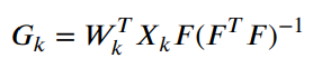

In [ ]:
import numpy as np

def gradian_G(k, X, G, W, F, alpha):
    """
    Compute the gradient of the cost function with respect to W_i.

    Parameters:
    - alpha: Constant scalar value.
    - X_i: Matrix X_i.
    - W_i: Matrix W_i.
    - F: Matrix F.
    - G_i: Matrix G_i.
    - Q_i: Matrix Q_i.

    Returns:
    - Gradient of the cost function with respect to W_i.
    """
    X = X[k]
    G = G[k]
    W = W[k]
    alpha = alpha[k]
    term1 = np.dot(W.T, np.dot(X, F))
    term2 = (F.T.dot(F))*(-1)
    term3 = term1.dot(term2)

    return term3


print(gradian_G(1, X, G, W, F, alpha).shape)

(50, 10)


In [ ]:
import numpy as np
from scipy.linalg import qr

def updateG(k, G, W, gradian_G, learning_rate, max_iters, convergence_criteria=None):
    """
    Gradient Descent with Projection onto the Orthogonal Group.

    Parameters:
    - W: Initial matrix W.
    - f: Cost function f(W).
    - grad_f: Gradient of the cost function with respect to W.
    - eta: Learning rate.
    - max_iters: Maximum number of iterations.
    - convergence_criteria (optional): Function to check for convergence.

    Returns:
    - Updated matrix W.
    """

    for iter in range(1, max_iters + 1):
        # Step 1: Compute the gradient of the cost function
        grad_G = gradian_G(k, X, G, W, F, alpha)
        G_k = G[k]

        # Step 2: Update W
        G_prime = G_k -  learning_rate * grad_G

        # Step 3: Check for convergence
        if convergence_criteria and convergence_criteria():
            print("Convergence criteria met. Stopping optimization.")
            break

    # Step 4: Output W
    return G[k]

print(updateG(1, G, W, gradian_G, 0.01, 10, convergence_criteria=None).shape)


(50, 10)


# **UPDATE F**

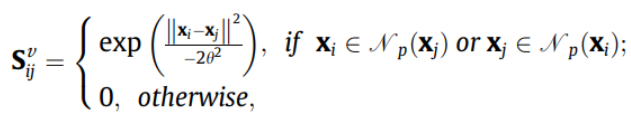

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import NearestNeighbors

def gaussian_kernel_similarity(X, p, h):
    """
    Compute the similarity matrix using a Gaussian kernel function.

    Parameters:
    - X: Data matrix of shape (d_features, n_samples)
    - p: Number of nearest neighbors
    - h: Kernel width

    Returns:
    - S: Similarity matrix of shape (n_samples, n_samples)
    """
    n_samples = X.shape[1]  # Number of samples is the second dimension

    # Compute pairwise distances
    distances = squareform(pdist(X.T, 'euclidean'))  # Transpose X to shape (n_samples, d_features)

    # Find the p-nearest neighbors for each point
    neighbors = NearestNeighbors(n_neighbors=p).fit(X.T)
    kneighbors = neighbors.kneighbors(X.T, return_distance=False)

    # Initialize similarity matrix
    S = np.zeros((n_samples, n_samples))

    # Compute similarity values for all pairs
    for i in range(n_samples):  # Iterate over each sample
        for j in range(n_samples):  # Iterate over each possible pair
            if i != j:
                # Check if j is one of the p-nearest neighbors of i
                if j in kneighbors[i]:
                    S[i, j] = np.exp(-distances[i, j]**2 / (2 * h**2))
                else:
                    S[i, j] = 0  # Ensure zero similarity for non-neighbors
                S[j, i] = S[i, j]  # Ensure symmetry

    return S

def construct_similarity_matrices(X_views, p, h):
    """
    Construct similarity matrices for multiple views and append them to a list.

    Parameters:
    - X_views: List of data matrices, one for each view
    - p: Number of nearest neighbors
    - h: Kernel width

    Returns:
    - S_matrices: List of similarity matrices
    """
    S_matrices = []
    for X in X_views:
        S = gaussian_kernel_similarity(X, p, h)
        S_matrices.append(S)
    return S_matrices

# Example usage
S_matrices = construct_similarity_matrices(X , p=5, h=1)


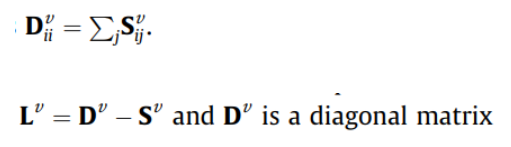

In [ ]:
def compute_laplacian_matrix(S):
    """
    Compute the Laplacian matrix from the similarity matrix.

    Parameters:
    - S: Similarity matrix of shape (n_samples, n_samples)

    Returns:
    - L: Laplacian matrix of shape (n_samples, n_samples)
    - D: Degree matrix of shape (n_samples, n_samples)
    """
    D = np.diag(np.sum(S, axis=1))
    L = D - S
    return L

def construct_similarity_and_laplacian_matrices(X_views, p, h):
    """
    Construct similarity matrices and Laplacian matrices for multiple views.

    Parameters:
    - X_views: List of data matrices, one for each view
    - p: Number of nearest neighbors
    - h: Kernel width

    Returns:
    - S_matrices: List of similarity matrices
    - L_matrices: List of Laplacian matrices
    """
    S_matrices = []
    L_matrices = []
    for X in X_views:
        S = gaussian_kernel_similarity(X, p, h)
        L = compute_laplacian_matrix(S)
        S_matrices.append(S)
        L_matrices.append(L)
    return S_matrices, L_matrices

In [ ]:
S_matrices, L_matrices = construct_similarity_and_laplacian_matrices(X, p=5, h=1)

In [ ]:
S_matrices[0].shape

(700, 700)

In [ ]:
L_matrices[0].shape

(700, 700)

In [ ]:
len(L_matrices)

3

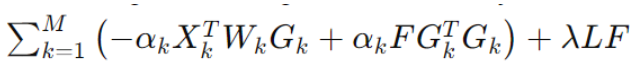

In [ ]:
import numpy as np

def gradient_F(X_views, W_views, G_views, alpha, L, lam, F):
    """
    Compute the gradient of the objective function with respect to F.

    Parameters:
    - X_views: List of data matrices for each view, X_k of shape (d, n)
    - W_views: List of transformation matrices for each view, W_k of shape (d, m)
    - G_views: List of transformation matrices for each view, G_k of shape (m, c)
    - alpha: List of weight parameters for each view, alpha_k
    - L: Laplacian matrix of shape (n, n)
    - lam: Regularization parameter, lambda
    - F: The matrix F of shape (n, c)

    Returns:
    - grad_F: The gradient of the objective function with respect to F
    """
    n = X_views[0].shape[1]
    c = G_views[0].shape[1]

    # Initialize the gradient accumulator
    grad_F = np.zeros((n, c))
    M = len(X_views)

    for k in range(M):
        X_k = X_views[k]
        W_k = W_views[k]
        G_k = G_views[k]
        alpha_k = alpha[k]
        L = L[k]

        # Gradient terms
        term1 = -alpha_k * (X_k.T @ W_k @ G_k)
        term2 = alpha_k * (F @ (G_k.T @ G_k))
        term3 = np.dot(L , F)
        grad_F += term1 + term2 + term3

    # Regularization term

    return grad_F

# Compute the gradient of the objective function with respect to F
grad_F = gradient_F(X, W, G, alpha, L_matrices, 1, F)

# Output the gradient
print("Gradient of the objective function with respect to F:\n", grad_F)
print("Gradient shape:", grad_F.shape)

Gradient of the objective function with respect to F:
 [[-2.74402133e+01 -3.67859263e+01 -3.44352002e+01 ... -3.29529243e+01
  -3.29768382e+01 -3.94586753e+01]
 [-4.67159214e+01 -5.89545913e+01 -5.55164895e+01 ... -4.83699321e+01
  -5.90250145e+01 -5.73541042e+01]
 [-3.56867824e+02 -4.46474295e+02 -4.24171159e+02 ... -3.62739229e+02
  -4.30411151e+02 -4.19396656e+02]
 ...
 [ 3.47854539e+01  4.78588771e+01  4.32270910e+01 ...  3.92543615e+01
   4.76748507e+01  4.91037528e+01]
 [ 1.40065052e+01  8.10607011e+00  6.96443669e+00 ...  7.80158485e+00
   1.02110709e+01  5.57263687e+00]
 [-5.29984895e+00 -8.18987218e+00 -2.10644798e-01 ... -2.04487408e+00
  -5.39339272e+00 -3.33154937e+00]]
Gradient shape: (700, 10)


In [ ]:
def update_F(W_k, X_k, G_k, F, Q_k, alpha_k, beta, learning_rate):
    """
    Update W_k using projection gradient descent.

    Parameters:
    beta (float): Scalar beta
    learning_rate (float): Learning rate for gradient descent

    Returns:
    numpy.ndarray: Updated orthogonal matrix W_k
    """
    grad = gradient_F(X, W, G, alpha, L_matrices, 1, F)
    F_prime = F - learning_rate * grad
    F_updated = make_orthogonal(F_prime)
    return F_updated

In [ ]:
updated_F = update_F(W, X, G, F, Q, alpha, 1, 0.01)

In [ ]:
print(updated_F)

[[-1.94899260e-02  1.83877005e-02  1.33205278e-02 ...  2.74390967e-03
   6.58457213e-03 -1.30094573e-02]
 [-2.74053886e-02  9.85934818e-02 -1.81504752e-02 ... -1.49675782e-03
   7.89206538e-03 -3.95575412e-03]
 [-1.81876460e-01 -2.22856693e-02  3.30297969e-02 ... -1.55533916e-02
   1.89386426e-02 -1.35955308e-02]
 ...
 [ 1.44023541e-02 -2.85834844e-02  2.30790909e-02 ... -2.21270084e-02
   8.87756364e-03 -1.09703564e-02]
 [-5.00367029e-04  8.68519025e-02 -1.66947584e-02 ...  5.04282372e-03
   4.71629716e-03 -4.45678609e-03]
 [-5.61943412e-03  1.68962745e-04 -2.64704056e-05 ... -5.36304291e-02
  -1.01195449e-01  8.78523670e-03]]


# **MAIN()**`

In [ ]:
import numpy as np

def optimize_matrices(X, F, G, W, max_iters, learning_rate, beta, alpha):
    # Unpack initial conditions
    updatedW = []
    updatedG = []

    for _ in range(max_iters):
        for k in range(len(W)):
            # Update Wk
            wk = updateW(k, W, learning_rate, max_iters, convergence_criteria=None)
            updatedW.append(wk)

            # Update Gk
            gk = updateG(k, G, W, gradian_G, learning_rate, max_iters, convergence_criteria=None)
            updatedG.append(gk)

        # Update F (outside the loop over k, since F is a single matrix)
        F = update_F(W, X, G, F, Q, alpha, 1, learning_rate)

    # Convert updatedW and updatedG to numpy arrays for consistency (optional)
    updatedW = np.array(updatedW)
    updatedG = np.array(updatedG)

    return updatedW, updatedG, F

# Ensure to define or import the update_Wk, update_G, and update_F functions
# as well as the gradian_f, alpha, eta, and any other necessary variables.


In [ ]:
 W_, G_, F_ = optimize_matrices(X, F, G, W, 10, 0.1, 1, alpha)

In [ ]:
F_new = F_

In [ ]:
import numpy as np

def binarize_F(F):
    """
    Binarize the clustering assignment matrix F.

    Parameters:
    F (numpy.ndarray): Clustering assignment matrix of shape (n_samples, n_clusters).

    Returns:
    numpy.ndarray: Binary clustering assignment matrix F (same shape as input).
    """
    # Create a binary matrix of the same shape as F
    F_binary = np.zeros_like(F)

    # Assign 1 to the index of the maximum value in each row
    max_indices = np.argmax(F, axis=1)
    F_binary[np.arange(F.shape[0]), max_indices] = 1

    return F_binary

def translate_to_cluster_labels(F_binary):
    """
    Translate the binary clustering assignment matrix F into cluster labels.

    Parameters:
    F_binary (numpy.ndarray): Binary clustering assignment matrix of shape (n_samples, n_clusters).

    Returns:
    numpy.ndarray: Cluster labels of shape (n_samples,).
    """
    # Find the index of the maximum value in each row
    cluster_labels = np.argmax(F_binary, axis=1)
    return cluster_labels

# Example usage
# Assuming F is the clustering assignment matrix obtained after projection gradient descent

# Binarize F
F_binary = binarize_F(F_new)
print("Binarized F:")
print(F_binary)
print(F_binary.shape)

# Translate the binary clustering assignment matrix F into cluster labels
cluster_labels = translate_to_cluster_labels(F_binary)


Binarized F:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
(700, 10)


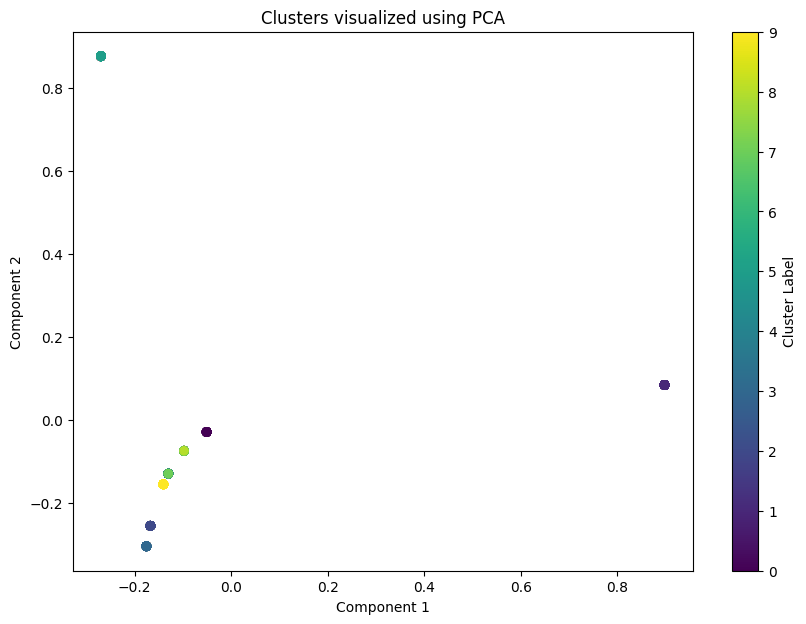

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_clusters(F, labels, method='PCA'):
    # Reduce dimensions for visualization
    if method == 'PCA':
        reducer = PCA(n_components=2)
    elif method == 'TSNE':
        reducer = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("Invalid method. Choose 'PCA' or 'TSNE'.")

    reduced_features = reducer.fit_transform(F)

    # Plot the clusters
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis')
    plt.title(f'Clusters visualized using {method}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(scatter, label='Cluster Label')
    plt.show()

# Example usage of the function
plot_clusters(F_binary, cluster_labels, method='PCA')


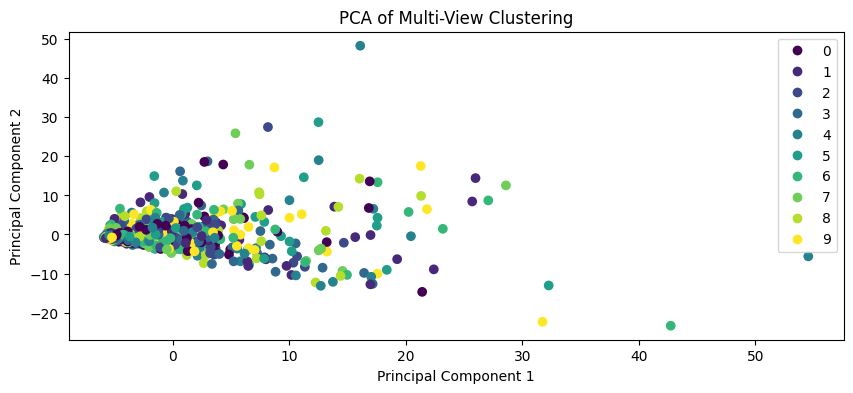

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
Xk_pca = pca.fit_transform(X[0].T)

cluster_assignments = np.argmax(F, axis=1)  # Get the cluster assignments from F

plt.figure(figsize=(10, 4))
scatter = plt.scatter(Xk_pca[:, 0], Xk_pca[:, 1], c=cluster_assignments, cmap='viridis')
plt.title('PCA of Multi-View Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(handles=scatter.legend_elements()[0], labels=list(set(cluster_assignments)))
plt.show()



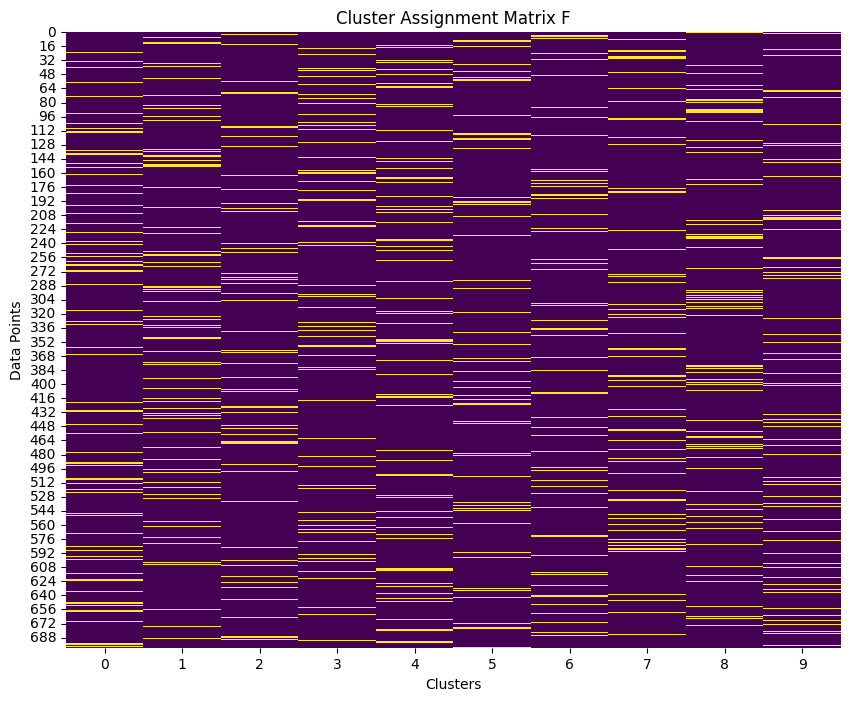

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming F is your clustering assignment matrix


# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(F, cmap='viridis', cbar=False)
plt.title('Cluster Assignment Matrix F')
plt.xlabel('Clusters')
plt.ylabel('Data Points')
plt.show()

Binary Cluster Assignment Matrix F_binary:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
Sum of rows in binary cluster assignment matrix:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 

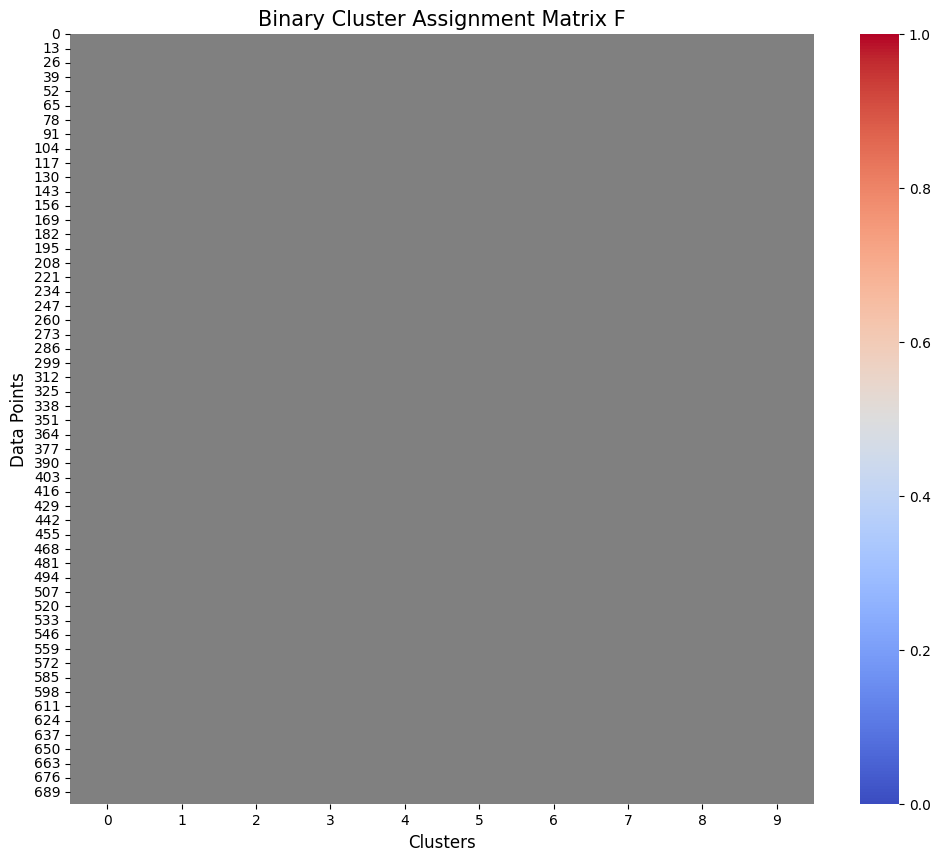

In [ ]:
#Step 1: Identify the cluster with the maximum value for each data point
cluster_assignments = np.argmax(F_new, axis=1)

# Step 2: Create a binary matrix
F_binary = np.zeros_like(F_new)
F_binary[np.arange(F_new.shape[0]), cluster_assignments] = 1

# Verify the binary cluster assignment
print("Binary Cluster Assignment Matrix F_binary:")
print(F_binary)

# Sum of rows should be all 1s
print("Sum of rows in binary cluster assignment matrix:")
print(F_binary.sum(axis=1))

# Plot the binary cluster assignment matrix
plt.figure(figsize=(12, 10))
sns.heatmap(F_binary, cmap='coolwarm', cbar=True, linewidths=0.1, linecolor='gray')
plt.title('Binary Cluster Assignment Matrix F', fontsize=15)
plt.xlabel('Clusters', fontsize=12)
plt.ylabel('Data Points', fontsize=12)
plt.show()

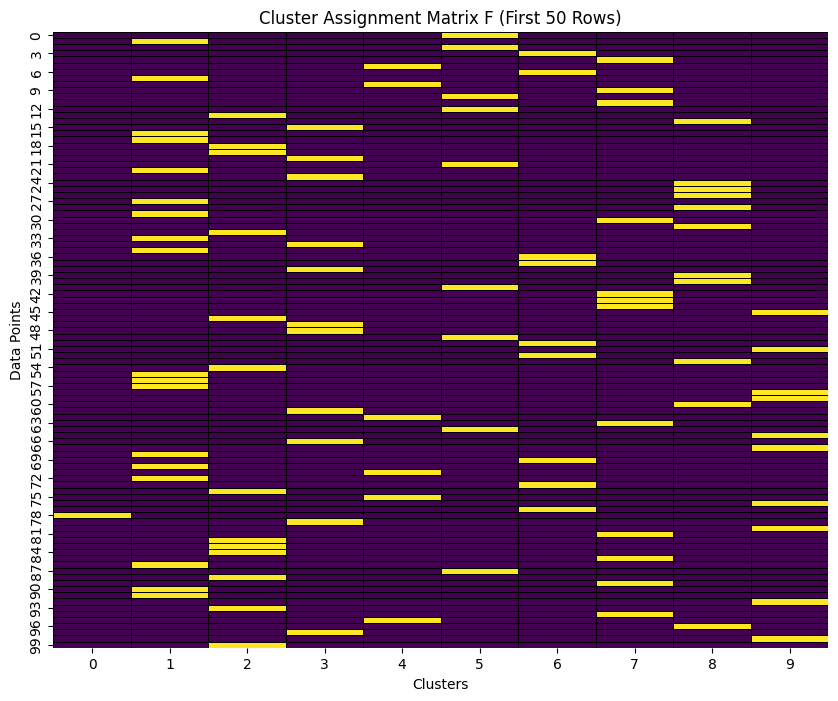

In [ ]:
F_sample = F_binary[:100, :]

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(F_sample, cmap='viridis', cbar=False, linewidths=0.5, linecolor='black')
plt.title('Cluster Assignment Matrix F (First 50 Rows)')
plt.xlabel('Clusters')
plt.ylabel('Data Points')
plt.show()


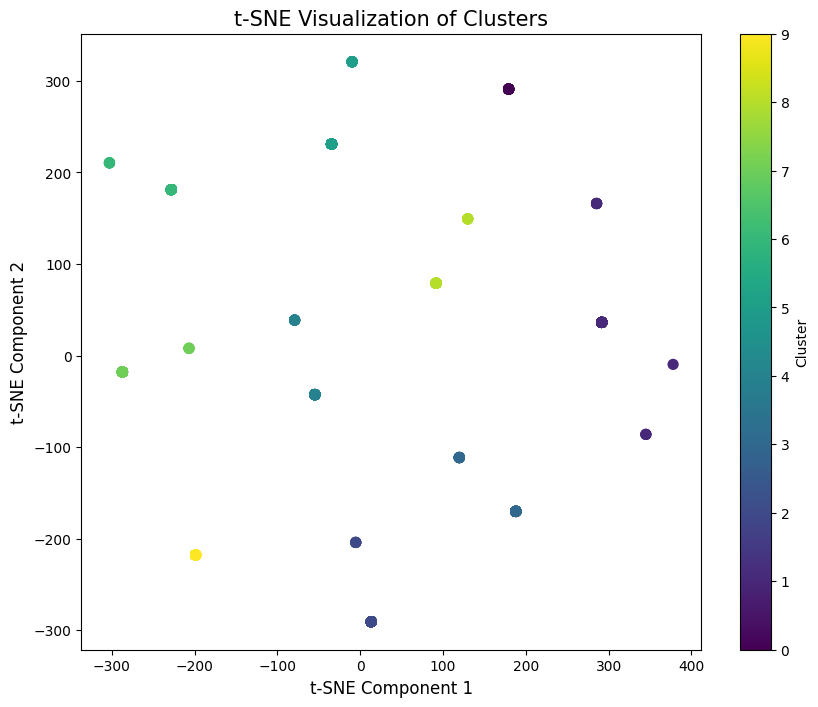

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Example F_new matrix with random values


# Run t-SNE to reduce the dimensions of F_new to 2D
tsne = TSNE(n_components=2, random_state=42)
F_new_2d = tsne.fit_transform(F_binary)

# Visualize the t-SNE result
plt.figure(figsize=(10, 8))
plt.scatter(F_new_2d[:, 0], F_new_2d[:, 1], c=np.argmax(F_new, axis=1), cmap='viridis', s=50)
plt.title('t-SNE Visualization of Clusters', fontsize=15)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.colorbar(label='Cluster')
plt.show()


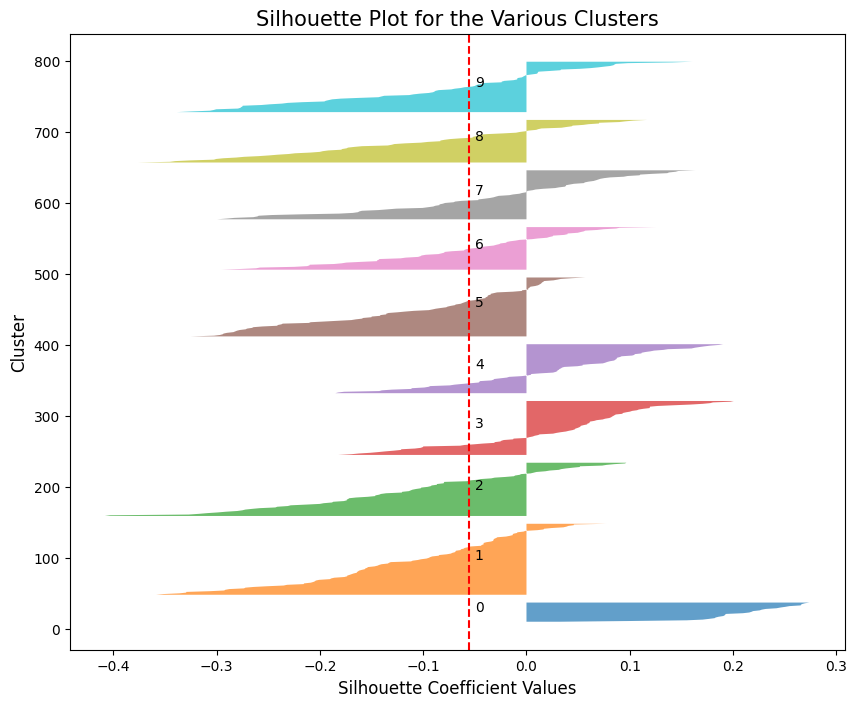

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score

# Example F_new matrix with random values
n_clusters = F_binary.shape[1]

# Step 1: Identify the cluster with the maximum value for each data point
cluster_assignments = np.argmax(F_binary, axis=1)

# Compute the silhouette scores for each sample
silhouette_vals = silhouette_samples(F_binary, cluster_assignments)
silhouette_avg = silhouette_score(F_binary, cluster_assignments)

# Step 2: Create a silhouette plot
plt.figure(figsize=(10, 8))
y_lower, y_upper = 10, 0
for i in range(n_clusters):
    cluster_silhouette_vals = silhouette_vals[cluster_assignments == i]
    cluster_silhouette_vals.sort()
    size_cluster = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster, str(i))
    y_lower = y_upper + 10

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.title('Silhouette Plot for the Various Clusters', fontsize=15)
plt.xlabel('Silhouette Coefficient Values', fontsize=12)
plt.ylabel('Cluster', fontsize=12)
plt.show()
